<a href="https://colab.research.google.com/github/edgarbc/genai-img-augmentation/blob/main/my_monai_panxray_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Variational autoencoder for panoramic x-rays using MONAI

by Edgar Bermudez - edgar.bermudez@gmail.com

October, 2023

(adapted from this tutotial in MONAI https://github.com/Project-MONAI/tutorials/blob/main/modules/varautoencoder_mednist.ipynb)

In [ ]:
import glob
from PIL import Image
import matplotlib.pyplot as plt
import os

# in order to access audio files (previously saved into google drive), we mount it
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Here I assume that you have uploaded your dataset into your google drive. The panoramic xray dataset that I am using here can be found as a Kaggle dataset (uploaded by somebody else) that comes from this paper.

In [ ]:
# make sure we are in the right place
datadir = 'drive/MyDrive/Colab Notebooks/xray_data/'
!pwd
! ls 'drive/MyDrive/Colab Notebooks/xray_data/'

/content
100.png  112.png  19.png  30.png  42.png  54.png  66.png  78.png  8.png
101.png  113.png  1.png   31.png  43.png  55.png  67.png  79.png  90.png
102.png  114.png  20.png  32.png  44.png  56.png  68.png  7.png   91.png
103.png  115.png  21.png  33.png  45.png  57.png  69.png  80.png  92.png
104.png  116.png  22.png  34.png  46.png  58.png  6.png   81.png  93.png
105.png  11.png   23.png  35.png  47.png  59.png  70.png  82.png  94.png
106.png  12.png   24.png  36.png  48.png  5.png   71.png  83.png  95.png
107.png  13.png   25.png  37.png  49.png  60.png  72.png  84.png  96.png
108.png  14.png   26.png  38.png  4.png   61.png  73.png  85.png  97.png
109.png  15.png   27.png  39.png  50.png  62.png  74.png  86.png  98.png
10.png	 16.png   28.png  3.png   51.png  63.png  75.png  87.png  99.png
110.png  17.png   29.png  40.png  52.png  64.png  76.png  88.png  9.png
111.png  18.png   2.png   41.png  53.png  65.png  77.png  89.png  preproc


In [ ]:
# check you can read the files from the datadir
fnames = glob.glob('drive/MyDrive/Colab Notebooks/xray_data/'+'*.png')
print(fnames[0])


drive/MyDrive/Colab Notebooks/xray_data/1.png


Now we can display the images. Note that this dataset is not normalized (image sizes are different across images).

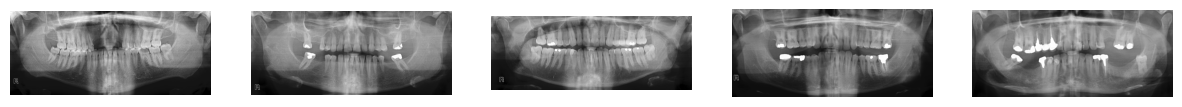

In [ ]:

# Take the first 'num_images' files
num_images = 5
selected_files = fnames[:num_images]

# Display the images in subplots
fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

for i, img_path in enumerate(selected_files):
    img = Image.open(img_path)
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')

plt.show()


Therefore, we can add a preprocessing fdunction to make sure we resize the images to the same size (we can add more preprocessing if needed later).

In [ ]:

# preprocess the dataset
def preprocess_images(input_directory, output_directory, target_size=(224, 224)):
    os.makedirs(output_directory, exist_ok=True)

    # List all image files in the input directory
    image_files = [f for f in os.listdir(input_directory) if f.endswith(('.jpg', '.png', '.jpeg'))]

    for image_file in image_files:
        # Load the image
        img_path = os.path.join(input_directory, image_file)
        img = Image.open(img_path)

        # Resize the image
        resized_img = img.resize(target_size)

        # Save the resized image to the output directory
        output_path = os.path.join(output_directory, image_file)
        resized_img.save(output_path)



In [ ]:
# Example usage:
input_directory = datadir  # Replace with your input directory
output_directory = datadir + "preproc/"
#target_size = (2700, 1200)  # Set the desired size
target_size = (600, 200)  # Set the desired size

In [ ]:
preprocess_images(datadir, output_directory, target_size)

After the preprocess the images, we can show a few of them to see the result.

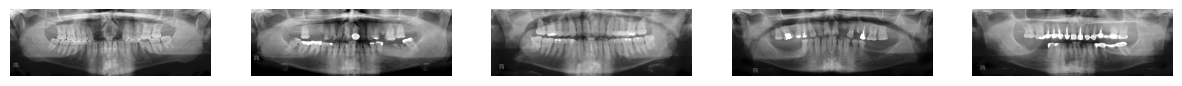

In [ ]:
# Take the first 'num_images' files
num_images = 5
selected_files = fnames[:num_images]

# Display the images in subplots
fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

for i, img_path in enumerate(selected_files):
    img = Image.open(img_path)
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')

plt.show()


Now lets prepare the dataset for training. We need to divide it into training and testing datasets. Note: since this dataset is particularly small, I am keeping the training set to the max size possible. Remember this is just for demonstration purposes, it would be better to have a larger dataset.

In [ ]:
# Split into training and testing
test_frac = 0.01
num_ims = len(fnames)
num_test = int(num_ims * test_frac)
num_train = num_ims - num_test
train_datadict = [{"im": fname} for fname in fnames[:num_train]]
test_datadict = [{"im": fname} for fname in fnames[-num_test:]]
print(f"total number of images: {num_ims}")
print(f"number of images for training: {len(train_datadict)}")
print(f"number of images for testing: {len(test_datadict)}")

total number of images: 116
number of images for training: 115
number of images for testing: 1


In [ ]:
# import monai or install it if it does not exist
!python -c "import monai" || pip install -q "monai-weekly[pillow]"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.6 MB/s eta 0:00:00


OK, now we need to import what we will use from monai to implement the autoencoder.

In [ ]:
import time
import pylab as pl
from IPython import display
import logging
import os
import shutil
import sys
import tempfile
import random
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import torch
from urllib.request import urlretrieve
import gzip
from PIL import Image

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.networks.nets import VarAutoEncoder
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    ScaleIntensityD,
    EnsureTypeD,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.3.dev2340
Numpy version: 1.23.5
Pytorch version: 2.0.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8d89083eeb8005babd7b5f76df83c1c80276cc10
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.3
Pillow version: 9.4.0
Tensorboard version: 2.13.0
gdown version: 4.6.6
TorchVision version: 0.15.2+cu118
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optiona

In [ ]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
set_determinism(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpnpp7uh5c


Create the image loaders. This might not be needed if the dataset is as small as my toy example but (like the in the MONAI tutorial) this can be helpful with large datasets.

In [ ]:
batch_size = 32 # 128
num_workers = 10

transforms = Compose(
    [
        LoadImageD(keys=["im"]),
        EnsureChannelFirstD(keys=["im"]),
        ScaleIntensityD(keys=["im"]),
        EnsureTypeD(keys=["im"]),
    ]
)

train_ds = CacheDataset(train_datadict, transforms, num_workers=num_workers)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_ds = CacheDataset(test_datadict, transforms, num_workers=num_workers)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

Loading dataset: 100%|██████████| 115/115 [00:00<00:00, 231.96it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loading dataset: 100%|██████████| 1/1 [00:00<00:00, 179.70it/s]


Now that we have the data prepared we define how we are going to train the autoencoder. We define the loss function that we will use and the Variational Autoencoder from MONAI.

In [ ]:
BCELoss = torch.nn.BCELoss(reduction="sum")


def loss_function(recon_x, x, mu, log_var, beta):
    bce = BCELoss(recon_x, x)
    kld = -0.5 * beta * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return bce + kld


def train(in_shape, max_epochs, latent_size, learning_rate, beta):
    model = VarAutoEncoder(
        spatial_dims=2,
        in_shape=in_shape,
        out_channels=1,
        latent_size=latent_size,
        channels=(16, 32, 64),
        strides=(1, 2, 2),
    ).to(device)

    # Create optimiser
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)

    avg_train_losses = []
    test_losses = []

    t = trange(max_epochs, leave=True, desc="epoch 0, average train loss: ?, test loss: ?")
    for epoch in t:
        model.train()
        epoch_loss = 0
        for batch_data in train_loader:
            inputs = batch_data["im"].to(device)
            optimizer.zero_grad()

            recon_batch, mu, log_var, _ = model(inputs)
            loss = loss_function(recon_batch, inputs, mu, log_var, beta)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_train_losses.append(epoch_loss / len(train_loader.dataset))

        # Test mode for validation
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch_data in test_loader:
                inputs = batch_data["im"].to(device)
                recon, mu, log_var, _ = model(inputs)
                # sum up batch loss
                test_loss += loss_function(recon, inputs, mu, log_var, beta).item()
        test_losses.append(test_loss / len(test_loader.dataset))

        t.set_description(
            f"epoch {epoch + 1}, average train loss: " f"{avg_train_losses[-1]:.4f}, test loss: {test_losses[-1]:.4f}"
        )
    return model, avg_train_losses, test_losses

Define the training parameters

In [ ]:

max_epochs = 500
learning_rate = 1e-4
beta = 100  # 100 KL beta weighting. increase for disentangled VAE
latent_size = 2
# VAE constructor needs image shape
im_shape = transforms(train_datadict[0])["im"].shape
print(im_shape)


torch.Size([1, 600, 200])


Now run the training. I experimentted with several parameters for this dataset.

In [ ]:
model, avg_train_losses, test_losses = train(im_shape, max_epochs, latent_size, learning_rate, beta)

epoch 500, average train loss: 73647.9109, test loss: 73513.2188: 100%|██████████| 500/500 [25:36<00:00,  3.07s/it]


Now lets plot the loss function over time for training

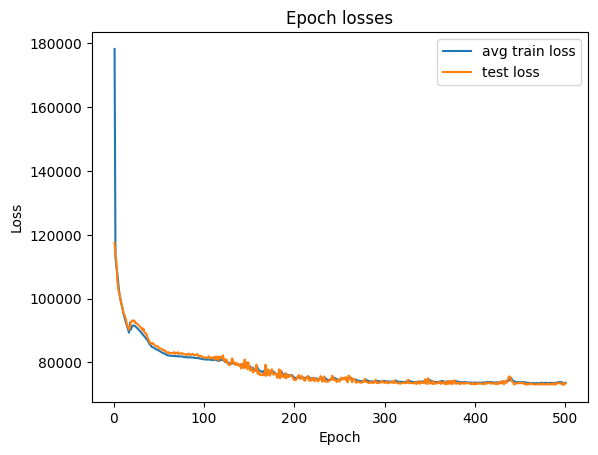

In [ ]:
plt.figure()
plt.title("Epoch losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
for y, label in zip([avg_train_losses, test_losses], ["avg train loss", "test loss"]):
    x = list(range(1, len(y) + 1))
    (line,) = plt.plot(x, y)
    line.set_label(label)
plt.legend()

Now lets sample the latent space and see the decoded images.

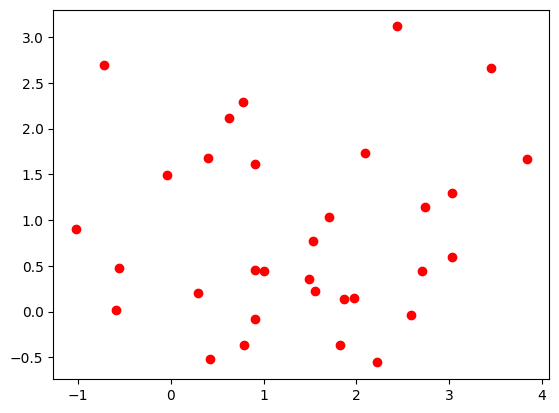

In [ ]:
for j, loader in enumerate([train_loader, test_loader]):
    for i, batch_data in enumerate(loader):
        inputs = batch_data["im"].to(device)
        o = model.reparameterize(*model.encode_forward(inputs)).detach().cpu().numpy()
        if i + j == 0:
            latent_coords = o
        else:
            np.vstack((latent_coords, o))

if latent_size < 4:
    fig = plt.figure()
    if latent_size == 2:
        plt.scatter(latent_coords[:, 0], latent_coords[:, 1], c="r", marker="o")
    elif latent_size == 3:
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(latent_coords[:, 0], latent_coords[:, 1], latent_coords[:, 2], c="r", marker="o")
        ax.set_xlabel("dim 1")
        ax.set_ylabel("dim 2")
        ax.set_zlabel("dim 3")

After we check the 2 dimensional latent space (red dots), now lets decode some samples to see them in xray (image) space.

In [ ]:
%matplotlib inline
num_ims = 10
pl.figure(figsize=(20, 12))
out = [[[] for _ in range(num_ims)] for _ in range(latent_size - 1)]
dist = torch.distributions.normal.Normal(torch.tensor(0.0), torch.tensor(1.0))
model.eval()

with torch.no_grad():
    for z in range(latent_size - 1):
        for z in range(latent_size - 1):
            for y, j in enumerate(torch.linspace(0.05, 0.95, num_ims)):
                for i in torch.linspace(0.05, 0.95, num_ims):
                    sample = torch.zeros(1, latent_size).to(device)
                    sample[0, z] = dist.icdf(j)
                    sample[0, z + 1] = dist.icdf(i)
                    o = model.decode_forward(sample)
                    o = o.detach().cpu().numpy().reshape(im_shape[1:])
                    out[z][y].append(o)

slices = np.block(out)


<Figure size 2000x1200 with 0 Axes>

After we decode the samples into the image space, we can display them

Text(0.5, 1.0, 'slice through dims 0 and 1 (through centre of other dims)')

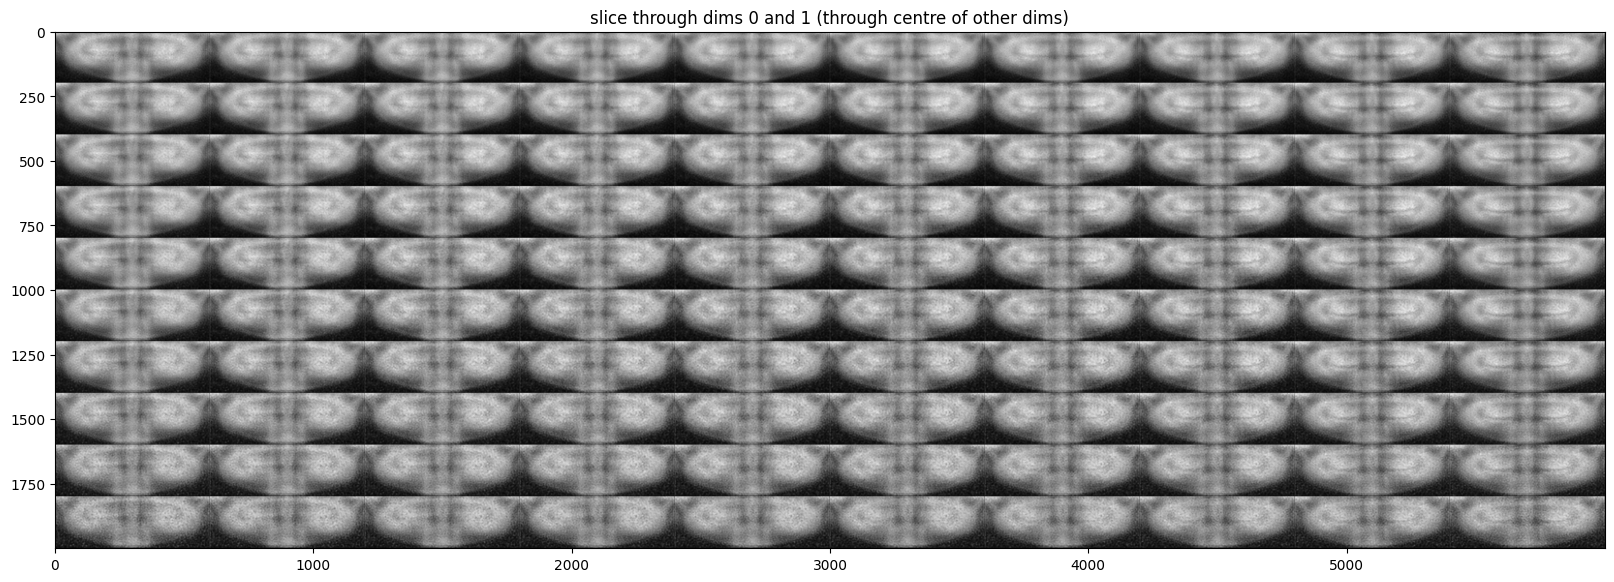

In [ ]:

%matplotlib inline
pl.figure(figsize=(20, 12))
pl.imshow(np.transpose(slices[i]), cmap='gray')
pl.title(f"slice through dims {i} and {i+1} (through centre of other dims)")
